# Gridworld with First Visit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# display output
from random import uniform
import random
import time
from IPython.display import display, clear_output

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) # total number of actions
gridSize = 5 # create a square grid of gridSize by gridSize
state_count = gridSize*gridSize # total number of states

In [3]:
class Gridworld():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        self.new_pos = [0, 0] # initialize new position for p_transition
        self.transition_prob = 1 # deterministic
    
    def initial_state(self):        # return initial state
        return grid.states[gridSize*gridSize-1]
   
    def transition_reward(self, current_pos, action): # return the transition probability

        # get next position: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_pos = np.array(current_pos) + np.array(action)

        # normally, reward = 0
        reward = 0

        # if new pos results in off the grid, return reward -1
        if -1 in self.new_pos or self.size in self.new_pos:
            reward = -1
        # if in state A, receive + 10
        if current_pos == [0, 1]:
            reward = 10
        # if in state B, receive + 5
        if current_pos == [0, 3]:
            reward = 5

        # if taking an action crosses the border; agent's new_pos is the same as the current pos
        if -1 in self.new_pos or self.size in self.new_pos: 
            self.new_pos = current_pos
            
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            self.new_pos = [4, 1]
            
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            self.new_pos = [2, 3]

        return self.new_pos, reward

## First-visit MC Control 

In [4]:
# create a grid object
grid = Gridworld(5)

In [5]:
# Initiate a random policy
random_policy = np.random.randint(1000, size=(state_count, action_count))
random_policy = random_policy/random_policy.sum(axis=1)[:,None]
policy = random_policy

In [6]:
# random policy
policy

array([[0.11851415, 0.27358491, 0.35495283, 0.25294811],
       [0.3401122 , 0.14340813, 0.21143058, 0.30504909],
       [0.10748299, 0.2399093 , 0.38231293, 0.27029478],
       [0.17849174, 0.3449353 , 0.43373494, 0.04283802],
       [0.18432602, 0.61191223, 0.03260188, 0.17115987],
       [0.0842246 , 0.34759358, 0.23529412, 0.3328877 ],
       [0.25945724, 0.3125    , 0.37993421, 0.04810855],
       [0.12749762, 0.06279734, 0.56041865, 0.24928639],
       [0.07398844, 0.08439306, 0.54393064, 0.29768786],
       [0.11073254, 0.60391823, 0.01788756, 0.26746167],
       [0.33757962, 0.25517516, 0.01512739, 0.39211783],
       [0.54123711, 0.21354934, 0.02798233, 0.21723122],
       [0.41946903, 0.05309735, 0.39911504, 0.12831858],
       [0.28431373, 0.24080882, 0.27297794, 0.20189951],
       [0.32541568, 0.22684086, 0.37767221, 0.07007126],
       [0.10424967, 0.06573705, 0.29017264, 0.53984064],
       [0.26892308, 0.11261538, 0.24861538, 0.36984615],
       [0.23596674, 0.43711019,

### Create an Episode following Policy

In [7]:
def generate_episode(steps):

    # set initial state
    state_vector = grid.initial_state()

    # initialize state (with iniitial state), action list and reward list
    state_list = [state_vector]
    action_list = []
    reward_list = []

    # generate an episode
    for i in range(steps):

        # pick an action based on categorical distribution in policy
        action_index = int(np.random.choice(action_count, 1, p=policy[grid.states.index(state_vector)])) 
        action_vector = actions[action_index] # convert the integer index (ie. 0) to action (ie. [-1, 0])

        # get new state and reward after taking action from current state
        new_state_vector, reward = grid.transition_reward(state_vector, action_vector)
        state_vector = list(new_state_vector)

        # save state, action chosen and reward to list
        state_list.append(state_vector)
        action_list.append(action_vector)
        reward_list.append(reward)
        
    return state_list, action_list, reward_list

### First Visit MC

In [8]:
# initialize q values for all state action pairs
Q_values = np.zeros((state_count, action_count))

In [9]:
# intialize parameters
gamma = 0.99
epsilon = 0.1

In [10]:
# define average function
def Average(lst): 
    return sum(lst) / len(lst) 

In [11]:
# iterate 500 times: each time, generating an episode of 200 steps
max_steps = 200

# define variables for keeping track of time steps
Terminal = max_steps
t_list=[]
for i in range(1,max_steps+1):
    t = Terminal - i
    t_list.append(t)

In [12]:
average_reward_list = []
cumulative_reward_list = []
cumulative_reward = 0
delta_list = []

# iteration 500 times
for iteration in range(500):
  
    # generate an episode of specified step count
    state_list, action_list, reward_list = generate_episode(max_steps)
    
    # calculate average reward of each episode
    average_reward_list.append(Average(reward_list))
    
    # obtain cumulative reward for plotting
    cumulative_reward = cumulative_reward + sum(reward_list)
    cumulative_reward_list.append(cumulative_reward)

    # intialize variables
    G = 0
    delta = 0
    
    # initiate returns and visited list to none
    returns_list = []
    visited_list = []

    # loop for each step of episode: T-1, T-2, T-3 ... 0 = 199, 198, 197 ... 0
    for t in t_list:

        # calculate G: starting with the last reward at index t (naturally accounts for pseudocode's "t-1")
        G = gamma*G + reward_list[t]
        
        # combine state action pair, for example, state = [0,0], action = [0,1], state_action_pair = [0,0,0,1]
        state_action_pair = []
        state_action_pair.extend(state_list[t])
        state_action_pair.extend(action_list[t])

        # check if state action pair have been visited before (if not: continue, else: move to the next time step)
        if state_action_pair not in visited_list:

            # add state action pair to visited list
            visited_list.append(state_action_pair)

            # append G to returns
            returns_list.append(G)

            # find state and action index, for example, converting action [-1, 0] to 0, and same for state #
            state_index = grid.states.index(state_list[t])
            action_index = actions.index(action_list[t])

            # calculate max delta change for plotting max q value change
            delta = max(delta, np.abs(Average(returns_list) - Q_values[state_index][action_index]))      
            
            # write Q_values to the state-action pair
            Q_values[state_index][action_index] = Average(returns_list)

            # choose best action at given state
            choose_action = np.argmax(Q_values[state_index])

            # overwrite policy
            for a in range(action_count): # for action in actions [0, 1, 2, 3]
                if choose_action == a: # if the choose_action is the same as the current action
                    policy[state_index][a] = 1 - epsilon + epsilon/action_count 
                else: # if choose_action is not the same as the current action
                    policy[state_index][a] = epsilon/action_count
    
    # append delta to list
    delta_list.append(delta)

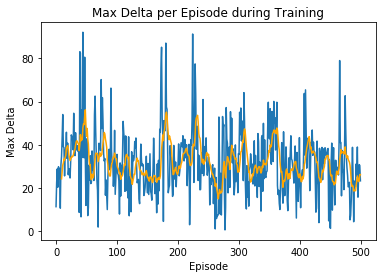

In [13]:
# max delta of each episode, where delta is the change in Q values
plt.plot(delta_list)
plt.title('Max Delta per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Max Delta')

# plot moving average
delta_frame = pd.DataFrame(delta_list)
rolling_mean = delta_frame.rolling(window=10).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

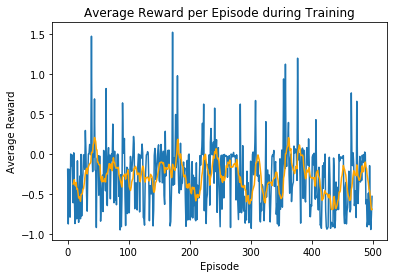

In [14]:
# average reward per episode
plt.plot(average_reward_list)
plt.title('Average Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

# plot moving average
reward_frame = pd.DataFrame(average_reward_list)
rolling_mean = reward_frame.rolling(window=10).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

Text(0, 0.5, 'Cumulative Reward')

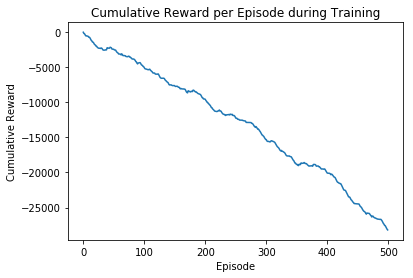

In [15]:
# cumulative reward per episode
plt.plot(cumulative_reward_list)
plt.title('Cumulative Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

In [17]:
np.set_printoptions(precision=2)
Q_values

array([[-1.00e+00, -3.91e+01, -1.01e+01, -6.44e+00],
       [-2.17e+01, -7.26e+00, -1.99e+01, -2.02e+01],
       [ 1.64e+01,  3.32e+00, -1.35e+00,  1.81e+00],
       [-1.08e+01,  2.50e+00,  3.07e+01, -3.96e-02],
       [-1.36e+01, -4.82e+00, -1.22e+01, -1.01e+01],
       [-7.85e+00, -1.77e+01, -5.65e+00, -6.68e+00],
       [-2.10e+01, -2.74e+01, -3.50e+01, -1.12e+01],
       [ 2.48e+00,  4.32e+00,  0.00e+00, -1.22e+01],
       [-3.77e+01, -2.11e+01, -1.00e+01, -2.67e+01],
       [-9.52e+00, -2.97e+01, -2.71e+01, -1.01e+01],
       [-7.55e+00, -9.21e+00, -4.39e+00, -6.51e+00],
       [-2.19e+01, -1.39e+01, -1.45e+01, -1.04e+01],
       [-1.31e+01,  0.00e+00, -1.55e+01,  0.00e+00],
       [-2.20e+01, -9.93e+00, -3.05e+01, -1.93e+01],
       [-1.01e+01, -1.01e+01, -8.38e+00, -1.90e+01],
       [-8.20e+00, -1.37e+01, -1.98e+00, -2.46e+00],
       [-1.22e+01, -1.65e+01, -1.37e+01, -9.95e+00],
       [-2.52e+01, -2.01e+01, -1.50e+01, -2.51e+01],
       [-2.28e+01, -2.91e+01, -2.78e+01, -1.66

In [18]:
policy

array([[0.93, 0.03, 0.03, 0.03],
       [0.03, 0.93, 0.03, 0.03],
       [0.93, 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.93, 0.03],
       [0.03, 0.93, 0.03, 0.03],
       [0.03, 0.03, 0.93, 0.03],
       [0.03, 0.03, 0.03, 0.93],
       [0.03, 0.93, 0.03, 0.03],
       [0.03, 0.03, 0.93, 0.03],
       [0.93, 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.93, 0.03],
       [0.03, 0.03, 0.03, 0.93],
       [0.03, 0.93, 0.03, 0.03],
       [0.03, 0.93, 0.03, 0.03],
       [0.03, 0.03, 0.93, 0.03],
       [0.03, 0.03, 0.93, 0.03],
       [0.03, 0.03, 0.03, 0.93],
       [0.03, 0.03, 0.93, 0.03],
       [0.03, 0.03, 0.03, 0.93],
       [0.03, 0.03, 0.93, 0.03],
       [0.03, 0.03, 0.93, 0.03],
       [0.03, 0.03, 0.93, 0.03],
       [0.03, 0.93, 0.03, 0.03],
       [0.03, 0.93, 0.03, 0.03],
       [0.03, 0.93, 0.03, 0.03]])

## Visualize 

In [19]:
# PRINT POLICY TABLE ################################################################################
# import pandas library
import pandas as pd
# define column and index
columns=range(grid.size)
index = range(grid.size)
# define dataframe to represent policy table
policy_table = pd.DataFrame(index = index, columns=columns)

# iterate through policy to make a table that represents action number
# as action name (eg. left, right, up, down)
for state in range(len(policy)):
    
    # find the best action at each state
    best_action = np.argmax(policy[state])

    # get action name
    if best_action == 0:
        action_name = 'up'
    elif best_action == 1:
        action_name = 'right'
    elif best_action == 2:
        action_name = 'down'
    else:
        action_name = 'left'

    # calculate the row and column coordinate of the current state number
    row = int(state/grid.size)
    column = round((state/grid.size - int(state/grid.size))*grid.size)
            
    # assign action name
    policy_table.loc[row][column] = action_name

print("Policy Table: ")
print(policy_table)
print()

Policy Table: 
      0      1      2      3      4
0    up  right     up   down  right
1  down   left  right   down     up
2  down   left  right  right   down
3  down   left   down   left   down
4  down   down  right  right  right



## Testing

In [20]:
avg_test_reward_list = []

# using the trained policy, generate 20 episodes
for test in range(20):
    
    # generate an episode of specified step count
    state_list, action_list, reward_list = generate_episode(max_steps)
    
    avg_test_reward_list.append(Average(reward_list))

Text(0, 0.5, 'Average Reward')

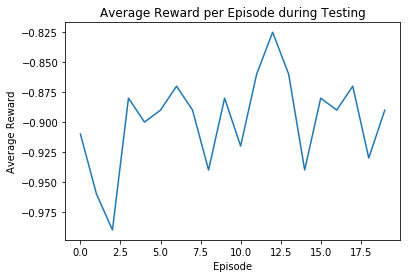

In [21]:
# average reward per episode
plt.plot(avg_test_reward_list)
plt.title('Average Reward per Episode during Testing')
plt.xlabel('Episode')
plt.ylabel('Average Reward')